In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
def get_r(beta):
    if beta<=1/2 or beta>1:
        print('ERROR : beta must be greater than 1/2 and inferior than 1')
        return
    if beta<=3/4:
        return beta-1/2
    if beta>3/4:
        return (1 - np.sqrt(1-beta))**2
    
q = 0.05
size = int(1e5)
gamma = 2
n_simu = 10

In [3]:
betas = [0.3, 0.5, 0.7]
rs = list(np.linspace(0.1, 1, 9))

In [ ]:
# Normal model

In [ ]:
res = {
    "BH": {beta: ({r: {'FDP': [], 'FNP': []} for r in (rs if beta != 0.7 else np.linspace(0.1, 1.5, 15))}) for beta in betas},
    "BC": {beta: ({r: {'FDP': [], 'FNP': []} for r in (rs if beta != 0.7 else np.linspace(0.1, 1.5, 15))}) for beta in betas}
}

In [ ]:
for beta in betas:

    size_false = int(size**(1-beta))
    size_true = int(size-size_false)

    for r in rs if beta!=0.7 else list(np.linspace(0.1, 1.5, 15)):

        for simu in range(n_simu):

            print(f"beta : {beta}; r : {r} ; n_simu : {simu}")

            mu = (gamma*r*np.log(size))**(1/gamma)

            ech_true = pd.DataFrame({'value': np.random.randn(size_true), 'distribution': True})
            ech_false = pd.DataFrame({'value': np.random.normal(mu, 1, size_false), 'distribution': False})
            ech = pd.concat((ech_true, ech_false))
            ech['p_value'] = stats.norm.sf(ech['value'])

            # BH Method :

            ech['reject_BH'] = False


            ech = ech.sort_values(by='p_value', ascending=True).reset_index(drop=True)
            ech['is_inferior'] = False
            for i in range(len(ech)):
                row = ech.iloc[i]
                p_val = row['p_value']
                idx = i+1
                val = q*idx/len(ech)
                if p_val <= val:
                    ech.at[i, 'is_inferior'] = True

            if len(ech[ech['is_inferior']==True].index>=1):
                k = ech[ech['is_inferior']==True].index[-1]
                
                for i in range(k+1):
                    ech.loc[i, 'reject_BH'] = True

            fp = ech[ech['reject_BH']==True]['distribution'].sum()
            fn = (1-ech[ech['reject_BH']==False]['distribution']).sum()
            tp = (1-ech[ech['reject_BH']==True]['distribution']).sum()
            tn = ech[ech['reject_BH']==False]['distribution'].sum()

            fdp = fp/(fp+tp)
            fnp = fn/(fn+tp)

            res["BH"][beta][r]['FDP'].append(fdp)
            res["BH"][beta][r]['FNP'].append(fnp)

            # BC Method :

            best_val = None  # Initialisation de best_val

            for val in ech['value']:
                value = abs(val)
                num = 1 + np.sum(ech['value'] <= -value)
                den = max(1, np.sum(ech['value'] >= value))
                fdp = num / den
                if best_val is None or (value <= best_val and fdp <= q):
                    best_val = value

            ech['reject_BC'] = False
            ech.loc[ech['value']>=best_val, 'reject_BC'] = True

            ech['reject_BC'] = False
            ech.loc[ech['value']>=best_val, 'reject_BC'] = True

            fp = ech[ech['reject_BC']==True]['distribution'].sum()
            fn = (1-ech[ech['reject_BC']==False]['distribution']).sum()
            tp = (1-ech[ech['reject_BC']==True]['distribution']).sum()
            tn = ech[ech['reject_BC']==False]['distribution'].sum()

            fdp = fp/(fp+tp)  if fp+tp!=0 else 0
            fnp = fn/(fn+tp)

            res["BC"][beta][r]['FDP'].append(fdp)
            res["BC"][beta][r]['FNP'].append(fnp)

In [119]:
file_path = 'results/resultat_normal.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(res, file)

In [120]:
file_path = 'resultat_normal.pkl'

with open(file_path, 'rb') as file:
    normal = pickle.load(file)

In [121]:
def get_mean(value):
    ssnan = [val for val in value if not math.isnan(val)]
    if len(ssnan)==0:
        return 0
    else:
        return np.mean(ssnan)

In [122]:
for beta in betas:
    for r in rs  if beta!=0.7 else list(np.linspace(0.1, 1.5, 15)):
        normal['BH'][beta][r]['FNR'] = np.mean(normal['BH'][beta][r]['FNP']) 
        normal['BH'][beta][r]['FDR'] = get_mean(normal['BH'][beta][r]['FDP'])
        normal['BC'][beta][r]['FNR'] = np.mean(normal['BC'][beta][r]['FNP'])
        normal['BC'][beta][r]['FDR'] = get_mean(normal['BC'][beta][r]['FDP'])

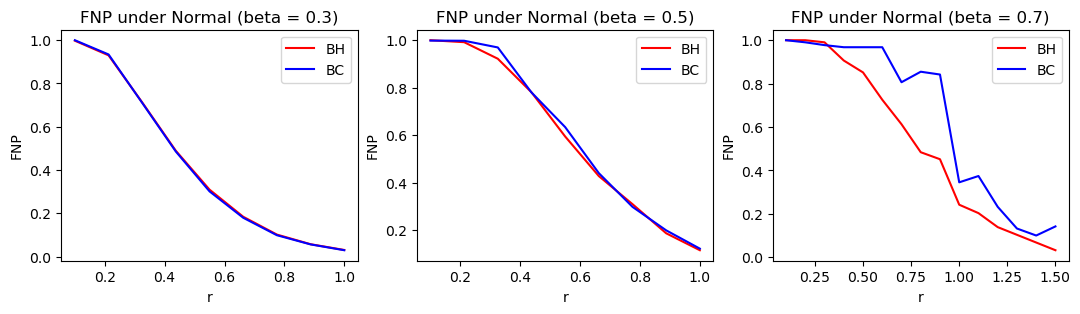

In [123]:
fig = plt.figure(figsize=(13, 3))

for i, beta in enumerate([0.3, 0.5, 0.7]):
    if beta!=0.7:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(rs, [normal['BH'][beta][r]['FNR'] for r in rs], label='BH', c='red')
        ax.plot(rs, [normal['BC'][beta][r]['FNR'] for r in rs], label='BC', c='blue')
        plt.title(f'FNP under Normal (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FNP')
        plt.legend()
    else:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [normal['BH'][beta][r]['FNR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BH', c='red')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [normal['BC'][beta][r]['FNR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BC', c='blue')
        plt.title(f'FNP under Normal (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FNP')
        plt.legend()

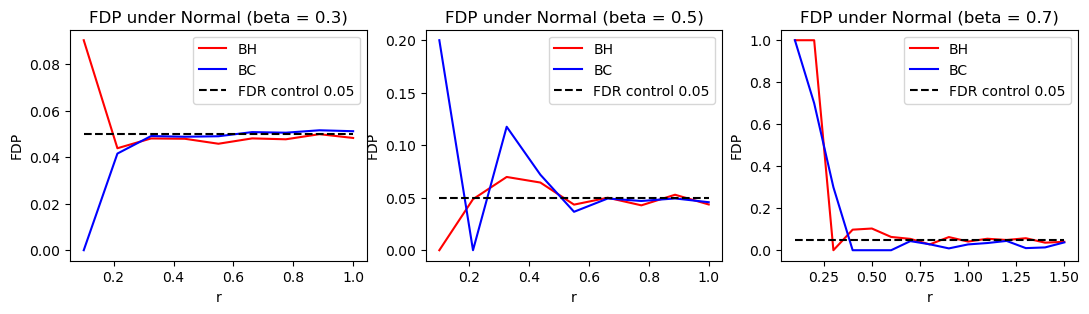

In [125]:
fig = plt.figure(figsize=(13, 3))

for i, beta in enumerate([0.3, 0.5, 0.7]):
    if beta!=0.7:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(rs, [normal['BH'][beta][r]['FDR'] for r in rs], label='BH', c='red')
        ax.plot(rs, [normal['BC'][beta][r]['FDR'] for r in rs], label='BC', c='blue')
        ax.plot(rs, np.ones(len(rs))*0.05, '--', label='FDR control 0.05', c='black')
        plt.title(f'FDP under Normal (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FDP')
        plt.legend()
    else:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [normal['BH'][beta][r]['FDR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BH', c='red')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [normal['BC'][beta][r]['FDR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BC', c='blue')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), np.ones(len(list(np.linspace(0.1, 1.5, 15))))*0.05, '--', label='FDR control 0.05', c='black')
        plt.title(f'FDP under Normal (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FDP')
        plt.legend() 

In [4]:
## Laplace Model

gamma=1

res = {
    "BH": {beta: ({r: {'FDP': [], 'FNP': []} for r in (rs if beta != 0.7 else np.linspace(0.1, 1.5, 15))}) for beta in betas},
    "BC": {beta: ({r: {'FDP': [], 'FNP': []} for r in (rs if beta != 0.7 else np.linspace(0.1, 1.5, 15))}) for beta in betas}
}

In [ ]:
# Laplace distribution
n_simu=10

for beta in betas:

    size_false = int(size**(1-beta))
    size_true = int(size-size_false)

    for r in rs if beta!=0.7 else list(np.linspace(0.1, 1.5, 15)):

        for simu in range(n_simu):

            print(f"beta : {beta}; r : {r} ; n_simu : {simu}")

            mu = (gamma*r*np.log(size))**(1/gamma)

            ech_true = pd.DataFrame({'value': np.random.laplace(0, 1, size_true), 'distribution': True})
            ech_false = pd.DataFrame({'value': np.random.laplace(mu, 1, size_false), 'distribution': False})
            ech = pd.concat((ech_true, ech_false))
            ech['p_value'] = stats.laplace.sf(ech['value'])

            # BH Method :

            ech['reject_BH'] = False


            ech = ech.sort_values(by='p_value', ascending=True).reset_index(drop=True)
            ech['is_inferior'] = False
            for i in range(len(ech)):
                row = ech.iloc[i]
                p_val = row['p_value']
                idx = i+1
                val = q*idx/len(ech)
                if p_val <= val:
                    ech.at[i, 'is_inferior'] = True

            if len(ech[ech['is_inferior']==True].index>=1):
                k = ech[ech['is_inferior']==True].index[-1]
                
                for i in range(k+1):
                    ech.loc[i, 'reject_BH'] = True

            fp = ech[ech['reject_BH']==True]['distribution'].sum()
            fn = (1-ech[ech['reject_BH']==False]['distribution']).sum()
            tp = (1-ech[ech['reject_BH']==True]['distribution']).sum()
            tn = ech[ech['reject_BH']==False]['distribution'].sum()

            fdp = fp/(fp+tp)  if fp+tp!=0 else 0
            fnp = fn/(fn+tp)

            res["BH"][beta][r]['FDP'].append(fdp)
            res["BH"][beta][r]['FNP'].append(fnp)

            # BC Method :

            best_val = None  # Initialisation de best_val

            for val in ech['value']:
                value = abs(val)
                num = 1 + np.sum(ech['value'] <= -value)
                den = max(1, np.sum(ech['value'] >= value))
                fdp = num / den
                if best_val is None or (value <= best_val and fdp <= q):
                    best_val = value

            ech['reject_BC'] = False
            ech.loc[ech['value']>=best_val, 'reject_BC'] = True

            ech['reject_BC'] = False
            ech.loc[ech['value']>=best_val, 'reject_BC'] = True

            fp = ech[ech['reject_BC']==True]['distribution'].sum()
            fn = (1-ech[ech['reject_BC']==False]['distribution']).sum()
            tp = (1-ech[ech['reject_BC']==True]['distribution']).sum()
            tn = ech[ech['reject_BC']==False]['distribution'].sum()

            fdp = fp/(fp+tp) if fp+tp!=0 else 0
            fnp = fn/(fn+tp)

            res["BC"][beta][r]['FDP'].append(fdp)
            res["BC"][beta][r]['FNP'].append(fnp)

In [6]:
file_path = 'results/resultat_laplace.pkl'

# Open file in binary write mode
with open(file_path, 'wb') as file:
    # Serialize and save the dictionary
    pickle.dump(res, file)

In [7]:
with open(file_path, 'rb') as file:
    laplace = pickle.load(file)

In [8]:
for beta in betas:
    for r in rs if beta!=0.7 else list(np.linspace(0.1, 1.5, 15)):
        laplace['BH'][beta][r]['FNR'] = np.mean(laplace['BH'][beta][r]['FNP'])
        laplace['BH'][beta][r]['FDR'] = np.mean(laplace['BH'][beta][r]['FDP'])
        laplace['BC'][beta][r]['FNR'] = np.mean(laplace['BC'][beta][r]['FNP'])
        laplace['BC'][beta][r]['FDR'] = np.mean(laplace['BC'][beta][r]['FDP'])

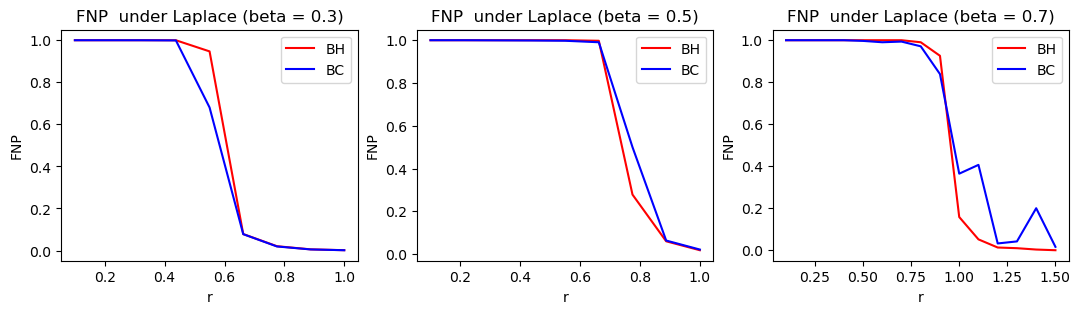

In [17]:
fig = plt.figure(figsize=(13, 3))

for i, beta in enumerate([0.3, 0.5, 0.7]):
    if beta!=0.7:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(rs, [laplace['BH'][beta][r]['FNR'] for r in rs], label='BH', c='red')
        ax.plot(rs, [laplace['BC'][beta][r]['FNR'] for r in rs], label='BC', c='blue')
        plt.title(f'FNP  under Laplace (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FNP')
        plt.legend()
    else:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [laplace['BH'][beta][r]['FNR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BH', c='red')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [laplace['BC'][beta][r]['FNR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BC', c='blue')
        
        plt.title(f'FNP  under Laplace (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FNP')
        plt.legend()

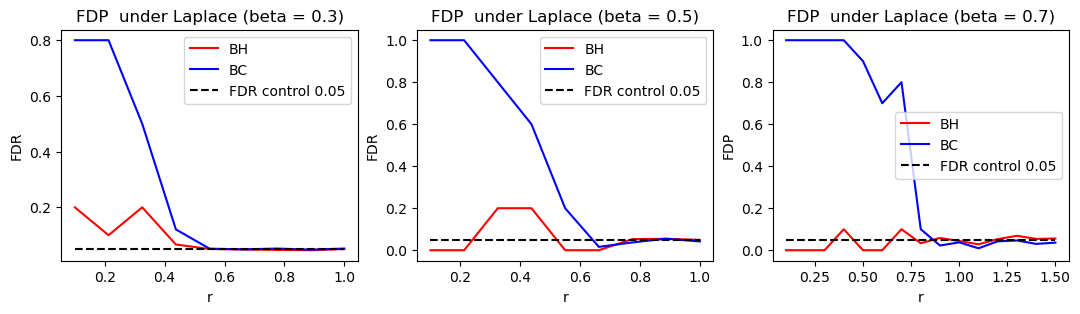

In [16]:
fig = plt.figure(figsize=(13, 3))

for i, beta in enumerate([0.3, 0.5, 0.7]):
    if beta!=0.7:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(rs, [laplace['BH'][beta][r]['FDR'] for r in rs], label='BH', c='red')
        ax.plot(rs, [laplace['BC'][beta][r]['FDR'] for r in rs], label='BC', c='blue')
        ax.plot(rs, np.ones(len(rs))*0.05, '--', label='FDR control 0.05', c='black')
        plt.title(f'FDP  under Laplace (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FDR')
        plt.legend()
    else:
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [laplace['BH'][beta][r]['FDR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BH', c='red')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), [laplace['BC'][beta][r]['FDR'] for r in list(np.linspace(0.1, 1.5, 15))], label='BC', c='blue')
        ax.plot(list(np.linspace(0.1, 1.5, 15)), np.ones(len(list(np.linspace(0.1, 1.5, 15))))*0.05, '--', label='FDR control 0.05', c='black')
        plt.title(f'FDP  under Laplace (beta = {beta})')
        plt.xlabel('r')
        plt.ylabel('FDP')
        plt.legend()    

In [18]:
# Varying sample size

In [64]:
# first setting under normal
gamma=2

beta, r = 0.7, 1.5

ns = [1e2, 1e3, 1e4, 1e5, 1e6]

res_normal = {
    "BH": {n:{"FDP":[], "FNP":[]} for n in ns},
    "BC": {n:{"FDP":[], "FNP":[]} for n in ns}
}

In [ ]:
for n in ns:
    q=1/np.log(n)
    mu = (gamma*r*np.log(n))**(1/gamma)

    size_false = int(n**(1-beta))
    size_true = int(n-size_false)

    for simu in range(n_simu):

        print(f"n={n}, simu={simu}")

        ech_true = pd.DataFrame({'value': np.random.randn(size_true), 'distribution': True})
        ech_false = pd.DataFrame({'value': np.random.normal(mu, 1, size_false), 'distribution': False})
        ech = pd.concat((ech_true, ech_false))
        ech['p_value'] = stats.norm.sf(ech['value'])

        # BH Method :

        ech['reject_BH'] = False


        ech = ech.sort_values(by='p_value', ascending=True).reset_index(drop=True)
        ech['is_inferior'] = False
        for i in range(len(ech)):
            row = ech.iloc[i]
            p_val = row['p_value']
            idx = i+1
            val = q*idx/len(ech)
            if p_val <= val:
                ech.at[i, 'is_inferior'] = True

        if len(ech[ech['is_inferior']==True].index>=1):
            k = ech[ech['is_inferior']==True].index[-1]
                
            for i in range(k+1):
                ech.loc[i, 'reject_BH'] = True

        fp = ech[ech['reject_BH']==True]['distribution'].sum()
        fn = (1-ech[ech['reject_BH']==False]['distribution']).sum()
        tp = (1-ech[ech['reject_BH']==True]['distribution']).sum()
        tn = ech[ech['reject_BH']==False]['distribution'].sum()

        fdp = fp/(fp+tp)  if fp+tp!=0 else 0
        fnp = fn/(fn+tp)

        res_normal["BH"][n]["FDP"].append(fdp)
        res_normal["BH"][n]['FNP'].append(fnp)
            
        # BC Method :

        best_val = None  # Initialisation de best_val

        for val in ech['value']:
            value = abs(val)
            num = 1 + np.sum(ech['value'] <= -value)
            den = max(1, np.sum(ech['value'] >= value))
            fdp = num / den
            if best_val is None or (value <= best_val and fdp <= q):
                best_val = value

        ech['reject_BC'] = False
        ech.loc[ech['value']>=best_val, 'reject_BC'] = True

        ech['reject_BC'] = False
        ech.loc[ech['value']>=best_val, 'reject_BC'] = True

        fp = ech[ech['reject_BC']==True]['distribution'].sum()
        fn = (1-ech[ech['reject_BC']==False]['distribution']).sum()
        tp = (1-ech[ech['reject_BC']==True]['distribution']).sum()
        tn = ech[ech['reject_BC']==False]['distribution'].sum()

        fdp = fp/(fp+tp) if fp+tp!=0 else 0
        fnp = fn/(fn+tp)

        res_normal["BC"][n]["FDP"].append(fdp)
        res_normal["BC"][n]['FNP'].append(fnp)

In [66]:
file_path = 'results/resultat_vary_normal_2.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(res_normal, file)

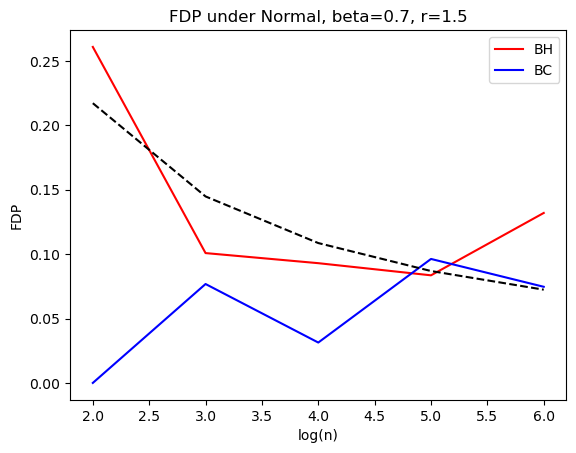

In [67]:
plt.plot(np.linspace(2, 6, 5), [np.mean(res_normal['BH'][n]['FDP']) for n in ns], label='BH', c='red')
plt.plot(np.linspace(2, 6, 5), [np.mean(res_normal['BC'][n]['FDP']) for n in ns], label='BC', c='blue')
plt.plot(np.linspace(2, 6, 5), 1/np.log(ns), '--', c='black')
plt.xlabel('log(n)')
plt.ylabel('FDP')
plt.title(f'FDP under Normal, beta={beta}, r={r}')
plt.legend()

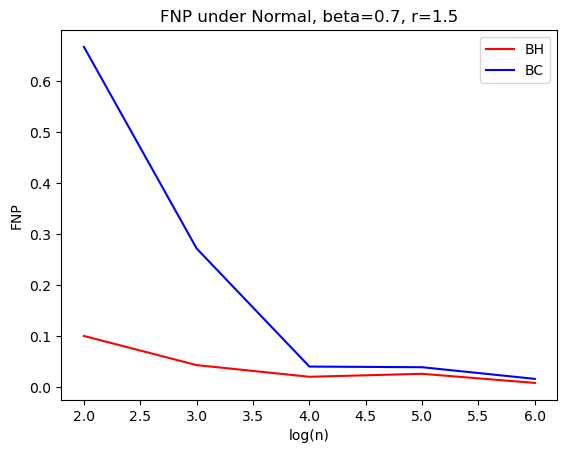

In [68]:
plt.plot(np.linspace(2, 6, 5), [np.mean(res_normal['BH'][n]['FNP']) for n in ns], label='BH', c='red')
plt.plot(np.linspace(2, 6, 5), [np.mean(res_normal['BC'][n]['FNP']) for n in ns], label='BC', c='blue')
plt.xlabel('log(n)')
plt.ylabel('FNP')
plt.title(f'FNP under Normal, beta={beta}, r={r}')
plt.legend()

In [69]:
# second setting under laplace
gamma=1

beta, r = 0.7, 1.2

ns = [1e2, 1e3, 1e4, 1e5, 1e6]

res_laplace = {
    "BH": {n:{"FDP":[], "FNP":[]} for n in ns},
    "BC": {n:{"FDP":[], "FNP":[]} for n in ns}
}

In [ ]:
for n in ns:
    q=1/np.log(n)
    mu = (gamma*r*np.log(n))**(1/gamma)

    size_false = int(n**(1-beta))
    size_true = int(n-size_false)

    for simu in range(n_simu):

        print(f"n={n}, simu={simu}")

        ech_true = pd.DataFrame({'value': np.random.laplace(0, 1, size_true), 'distribution': True})
        ech_false = pd.DataFrame({'value': np.random.laplace(mu, 1, size_false), 'distribution': False})
        ech = pd.concat((ech_true, ech_false))
        ech['p_value'] = stats.laplace.sf(ech['value'])

        # BH Method :

        ech['reject_BH'] = False


        ech = ech.sort_values(by='p_value', ascending=True).reset_index(drop=True)
        ech['is_inferior'] = False
        for i in range(len(ech)):
            row = ech.iloc[i]
            p_val = row['p_value']
            idx = i+1
            val = q*idx/len(ech)
            if p_val <= val:
                ech.at[i, 'is_inferior'] = True

        if len(ech[ech['is_inferior']==True].index>=1):
            k = ech[ech['is_inferior']==True].index[-1]
                
            for i in range(k+1):
                ech.loc[i, 'reject_BH'] = True

        fp = ech[ech['reject_BH']==True]['distribution'].sum()
        fn = (1-ech[ech['reject_BH']==False]['distribution']).sum()
        tp = (1-ech[ech['reject_BH']==True]['distribution']).sum()
        tn = ech[ech['reject_BH']==False]['distribution'].sum()

        fdp = fp/(fp+tp)  if fp+tp!=0 else 0
        fnp = fn/(fn+tp)

        res_laplace["BH"][n]["FDP"].append(fdp)
        res_laplace["BH"][n]['FNP'].append(fnp)
            
        # BC Method :

        best_val = None  # Initialisation de best_val

        for val in ech['value']:
            value = abs(val)
            num = 1 + np.sum(ech['value'] <= -value)
            den = max(1, np.sum(ech['value'] >= value))
            fdp = num / den
            if best_val is None or (value <= best_val and fdp <= q):
                best_val = value

        ech['reject_BC'] = False
        ech.loc[ech['value']>=best_val, 'reject_BC'] = True

        ech['reject_BC'] = False
        ech.loc[ech['value']>=best_val, 'reject_BC'] = True

        fp = ech[ech['reject_BC']==True]['distribution'].sum()
        fn = (1-ech[ech['reject_BC']==False]['distribution']).sum()
        tp = (1-ech[ech['reject_BC']==True]['distribution']).sum()
        tn = ech[ech['reject_BC']==False]['distribution'].sum()

        fdp = fp/(fp+tp) if fp+tp!=0 else 0
        fnp = fn/(fn+tp)

        res_laplace["BC"][n]["FDP"].append(fdp)
        res_laplace["BC"][n]['FNP'].append(fnp)

In [71]:
file_path = 'results/resultat_vary_laplace_2.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(res_laplace, file)

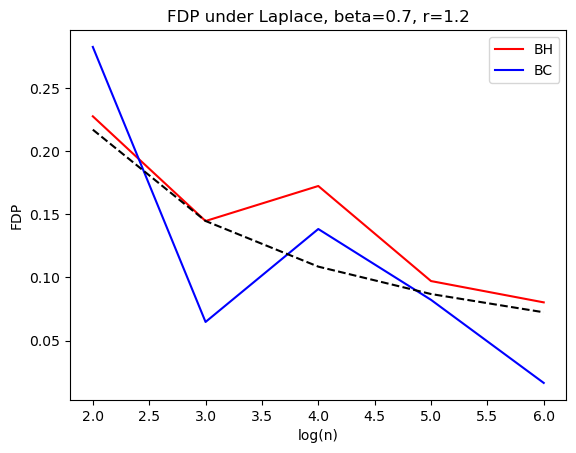

In [72]:
plt.plot(np.linspace(2, 6, 5), [np.mean(res_laplace['BH'][n]['FDP']) for n in ns], label='BH', c='red')
plt.plot(np.linspace(2, 6, 5), [np.mean(res_laplace['BC'][n]['FDP']) for n in ns], label='BC', c='blue')
plt.plot(np.linspace(2, 6, 5), 1/np.log(ns), '--', c='black')
plt.xlabel('log(n)')
plt.ylabel('FDP')
plt.title(f'FDP under Laplace, beta={beta}, r={r}')
plt.legend()

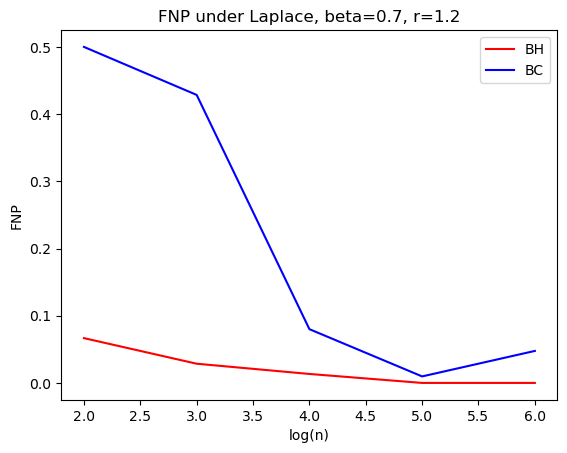

In [73]:
plt.plot(np.linspace(2, 6, 5), [np.mean(res_laplace['BH'][n]['FNP']) for n in ns], label='BH', c='red')
plt.plot(np.linspace(2, 6, 5), [np.mean(res_laplace['BC'][n]['FNP']) for n in ns], label='BC', c='blue')
plt.xlabel('log(n)')
plt.ylabel('FNP')
plt.title(f'FNP under Laplace, beta={beta}, r={r}')
plt.legend()